<a href="https://colab.research.google.com/github/knlpscience/Traffic-Accident-Injury-Prediction-Competition/blob/main/%EB%8C%80%EA%B5%AC_%EA%B5%90%ED%86%B5%EC%82%AC%EA%B3%A0_%ED%94%BC%ED%95%B4_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C(torch_model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install category_encoders
!pip install wandb
!pip install lightning

In [125]:
import os
import random
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from category_encoders.target_encoder import TargetEncoder


def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(42)

# data path
path = '/content/drive/MyDrive/Colab Notebooks/DACON/교통사고 data'

# origin data
train = pd.read_csv(f'{path}/train.csv')
test = pd.read_csv(f'{path}/test.csv')

train_df = train.copy()
test_df = test.copy()

# pattern
location_pattern = r'(\S+) (\S+) (\S+) (\S+)'

In [126]:
# 보안등
light_df = pd.read_csv(f'{path}/external_open/대구 보안등 정보.csv', encoding='cp949', usecols=['설치개수', '소재지지번주소'])
light_df[['도시', '구', '동', '번지']] = light_df['소재지지번주소'].str.extract(location_pattern)
light_df.drop(columns=['소재지지번주소', '번지'], inplace=True)
light_df = light_df.groupby(['도시', '구', '동']).sum().reset_index()

# 어린이 보호 구역
child_area_df = pd.read_csv(f'{path}/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949', usecols=['소재지지번주소']).drop_duplicates()
child_area_df['cnt'] = 1
child_area_df[['도시', '구', '동', '번지']] = child_area_df['소재지지번주소'].str.extract(location_pattern)
child_area_df.drop(columns=['소재지지번주소', '번지'], inplace=True)
child_area_df = child_area_df.groupby(['도시', '구', '동']).sum().reset_index()

# 주차장
parking_df = pd.read_csv(f'{path}/external_open/대구 주차장 정보.csv', encoding='cp949', usecols=['소재지지번주소', '급지구분'])
parking_df = pd.get_dummies(parking_df, columns=['급지구분'])
parking_df[['도시', '구', '동', '번지']] = parking_df['소재지지번주소'].str.extract(location_pattern)
parking_df.drop(columns=['소재지지번주소', '번지'], inplace=True)
parking_df = parking_df.groupby(['도시', '구', '동']).sum().reset_index()

In [130]:
def extract_location_columns(df, source_column, pattern, new_columns):
    df[new_columns] = df[source_column].str.extract(pattern)
    df.drop(columns=[source_column], inplace=True)
    return df

# 시군구
location_pattern = r'(\S+) (\S+) (\S+)'
train_df = extract_location_columns(train_df, '시군구', location_pattern, ['도시', '구', '동'])
test_df = extract_location_columns(test_df, '시군구', location_pattern, ['도시', '구', '동'])

# 도로형태
road_pattern = r'(.+) - (.+)'
train_df = extract_location_columns(train_df, '도로형태', road_pattern, ['도로형태1', '도로형태2'])
test_df = extract_location_columns(test_df, '도로형태', road_pattern, ['도로형태1', '도로형태2'])

In [129]:
# 날짜 처리
def process_datetime(df):
    df['사고일시'] = pd.to_datetime(df['사고일시'])
    df['년'] = df['사고일시'].dt.year
    df['월'] = df['사고일시'].dt.month
    df['일'] = df['사고일시'].dt.day
    df['시'] = df['사고일시'].dt.hour
    df.drop(columns='사고일시', inplace=True)
    return df

train_df = process_datetime(train_df)
test_df = process_datetime(test_df)

In [131]:
# 데이터 프레임 병합
def merge_dataframes(base_df, dfs_to_merge, join_keys, join_type='left'):
    for df in dfs_to_merge:
        base_df = pd.merge(base_df, df, how=join_type, on=join_keys)
    return base_df

dfs_to_merge = [light_df, child_area_df, parking_df]

train_df = merge_dataframes(train_df, dfs_to_merge, ['도시', '구', '동'])
test_df = merge_dataframes(test_df, dfs_to_merge, ['도시', '구', '동'])

In [132]:
X_test = test_df.drop(columns=['ID']).copy()
X_train = train_df[X_test.columns].copy()
y_train = train_df['ECLO'].copy()

In [133]:
# 카테고리 특성 처리
categorical_features = list(X_train.dtypes[X_train.dtypes == "object"].index)
print(f'카테고리 변수: {categorical_features}')

for i in categorical_features:
    le = TargetEncoder(cols=[i])
    X_train[i] = le.fit_transform(X_train[i], y_train)
    X_test[i] = le.transform(X_test[i])

display(X_train.head())
display(X_test.head())

['요일', '기상상태', '노면상태', '사고유형', '도시', '구', '동', '도로형태1', '도로형태2']

,요일,기상상태,노면상태,사고유형,년,월,일,시,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.627926,4.712888,4.712878,3.817650,2019,1,1,0,4.726704,4.541610,4.282449,4.671841,4.599599,391.0,2.0,11.0,0.0,0.0
1,4.627926,4.779150,4.712878,3.817650,2019,1,1,0,4.726704,4.618441,4.738938,4.671841,4.599599,932.0,NaN,0.0,1.0,3.0
2,4.627926,4.712888,4.712878,3.817650,2019,1,1,1,4.726704,4.727300,4.842715,4.671841,4.599599,473.0,4.0,NaN,NaN,NaN
3,4.627926,4.712888,4.712878,4.944597,2019,1,1,2,4.726704,4.687669,4.208920,4.671841,4.599599,534.0,11.0,0.0,9.0,5.0
4,4.627926,4.712888,4.712878,4.944597,2019,1,1,4,4.726704,4.889534,4.549091,4.671841,4.599599,2057.0,NaN,0.0,1.0,0.0


,요일,기상상태,노면상태,사고유형,년,월,일,시,도시,구,동,도로형태1,도로형태2,설치개수,cnt,급지구분_1,급지구분_2,급지구분_3
0,4.920811,4.712888,4.712878,3.817650,2022,1,1,1,4.726704,4.727300,4.881657,4.882281,5.006142,700.0,4.0,NaN,NaN,NaN
1,4.920811,4.712888,4.712878,3.817650,2022,1,1,1,4.726704,4.727300,4.563008,4.671841,4.599599,NaN,10.0,0.0,0.0,2.0
2,4.920811,4.712888,4.712878,4.944597,2022,1,1,4,4.726704,4.727300,4.945578,4.882281,5.006142,NaN,1.0,NaN,NaN,NaN
3,4.920811,4.712888,4.712878,4.944597,2022,1,1,4,4.726704,4.727300,4.438172,4.671841,4.599599,NaN,7.0,0.0,2.0,1.0
4,4.920811,4.712888,4.712878,4.944597,2022,1,1,6,4.726704,4.618441,4.738938,4.882281,5.006142,932.0,NaN,0.0,1.0,3.0


In [134]:
# 결측치 처리
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# pytorch

In [170]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from lightning.pytorch.loggers import WandbLogger

wandb_logger = WandbLogger(project="Traffic Acc.")

def rmsle(y_true, y_pred):
    y_true = torch.log1p(y_true)
    y_pred = torch.log1p(y_pred)
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))

class TrafficDataModule(pl.LightningDataModule):
    def __init__(self, train_x, train_y, valid_x, valid_y, batch_size=32):
        super().__init__()
        self.train_x = train_x
        self.train_y = train_y
        self.valid_x = valid_x
        self.valid_y = valid_y
        self.batch_size = batch_size

    def train_dataloader(self):
        train_dataset = TensorDataset(torch.tensor(self.train_x.values).float(), torch.tensor(self.train_y.values).float())
        return DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        valid_dataset = TensorDataset(torch.tensor(self.valid_x.values).float(), torch.tensor(self.valid_y.values).float())
        return DataLoader(valid_dataset, batch_size=self.batch_size)

class TrafficModel(pl.LightningModule):
    def __init__(self, input_size):
        super(TrafficModel, self).__init__()
        self.batch_norm = nn.BatchNorm1d(input_size, eps=0.00001)
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.batch_norm(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = rmsle(y, y_pred)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x).squeeze()
        loss = rmsle(y, y_pred)
        self.log('valid_loss', loss)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x = batch[0]
        return self(x).squeeze()

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.001)

# WandB 초기화 (필요한 경우)
wandb.init(project="Traffic Accident")

# 데이터셋 준비
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
data_module = TrafficDataModule(train_x, train_y, valid_x, valid_y)

# 모델 초기화 및 트레이너 설정
model = TrafficModel(input_size=len(train_x.columns))
trainer = pl.Trainer(max_epochs=50, logger=wandb_logger)
trainer.fit(model, datamodule=data_module)

# 예측 결과 처리
pred_loader = DataLoader(TensorDataset(torch.tensor(X_test.values).float()), batch_size=32)
predictions = trainer.predict(model, dataloaders=pred_loader)

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▁▁▁▂▂▂▂▂▂▁▂▂▁▂▁▂▃▂▂▂
trainer/global_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇███
valid_loss,▁
epoch,0
train_loss,0.47985
trainer/global_step,1113
valid_loss,0.434


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type        | Params
-------------------------------------------
0 | batch_norm | BatchNorm1d | 36    
1 | fc1        | Linear      | 304   
2 | fc2        | Linear      | 544   
3 | fc3        | Linear      | 33    
4 | relu       | ReLU        | 0     
-------------------------------------------
917       Trainable params
0         Non-trainable pa

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

In [138]:
sample_submission = pd.read_csv(f'{path}/sample_submission.csv')
sample_submission["ECLO"] = predictions
sample_submission.to_csv("submission.csv", index=False)

# submission 비교용

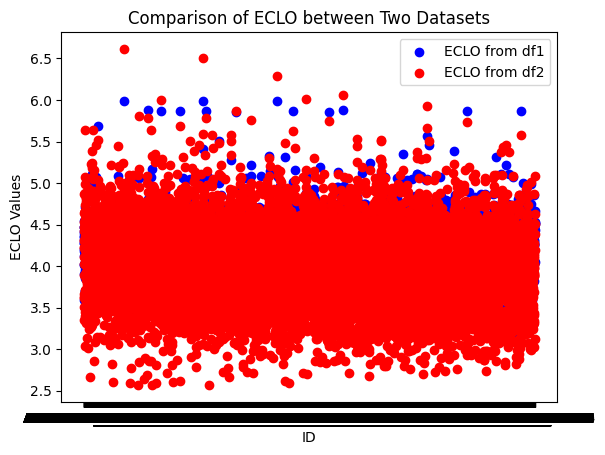

In [139]:
import matplotlib.pyplot as plt

df1 = pd.read_csv('/content/submission (4).csv')
df2 = pd.read_csv('/content/submission.csv')

# 'ID' 컬럼을 기준으로 각 데이터프레임 정렬
df1_sorted = df1.sort_values(by='ID')
df2_sorted = df2.sort_values(by='ID')

# 'ID'가 같은 행끼리 'ECLO' 값을 비교하기 위해 두 데이터프레임 병합
merged_df = pd.merge(df1_sorted, df2_sorted, on='ID', suffixes=('_df1', '_df2'))

# 각 데이터셋의 ECLO 값에 대한 산점도
plt.scatter(merged_df['ID'], merged_df['ECLO_df1'], color='blue', label='ECLO from df1')
plt.scatter(merged_df['ID'], merged_df['ECLO_df2'], color='red', label='ECLO from df2')

plt.xlabel('ID')
plt.ylabel('ECLO Values')
plt.title('Comparison of ECLO between Two Datasets')
plt.legend()
plt.show()